In [1]:
from sympy import *
init_printing(order='none')
# Givens
r_w = symbols("r_w", real=True, finite=True, positive=True)
r_p = symbols("r_p", real=True, finite=True, positive=True)
I_p = symbols("I_p", real=True, finite=True, positive=True)
I_w = symbols("I_w", real=True, finite=True, positive=True)
m_p = symbols("m_p", real=True, finite=True, positive=True)
v_p = symbols("v_p", real=True, finite=True, positive=True)

# Unknowns
omega_wi = symbols("\\omega_{wi}", real=True, finite=True, positive=True)
omega_wf = symbols("\\omega_{wf}", real=True, finite=True, positive=True)
omega_p = symbols("\\omega_p", real=True, finite=True, positive=True)
J_w = symbols("J_w", real=True, finite=True, positive=True)
J_h = symbols("J_h", real=True, finite=True, positive=True)

from IPython.display import Markdown

def display_eq(eq, label, uneval_exprs=[]):
    for e in uneval_exprs:
        eq = eq.subs(e, UnevaluatedExpr(e))
    return display(Markdown(f'<div style="text-align: center">\n\n#### {label}\n\n</div>\n\n' + '\\begin{equation}\n' + f'{latex(eq)}' + ' \\end{equation}'))

# Flywheel Shooter Analysis

Dean Brettle  
Mentor  
FRC Team 199, Deep Blue

## Abstract

We describe a new mathematical model for the physics of a hooded flywheel shooter, derive equations for the initial wheel velocity and the ratio of the initial wheel velocity to the final wheel velocity, and compare our analysis and results to previous work. Our analysis predictis that the wheel speed lost during a show is half of what is predicted by previous work.

## Introduction

Consider the following drawing of a hooded flywheel shooter:



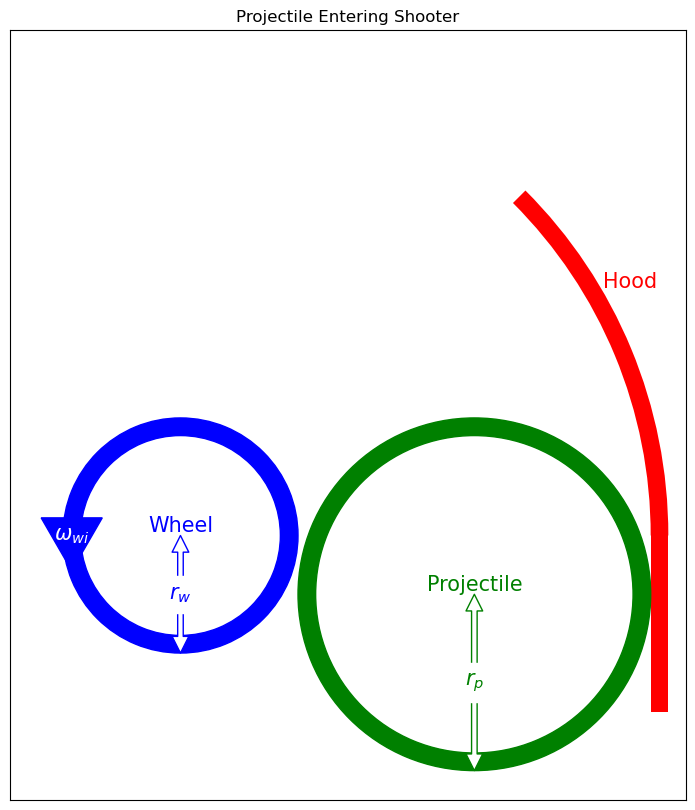

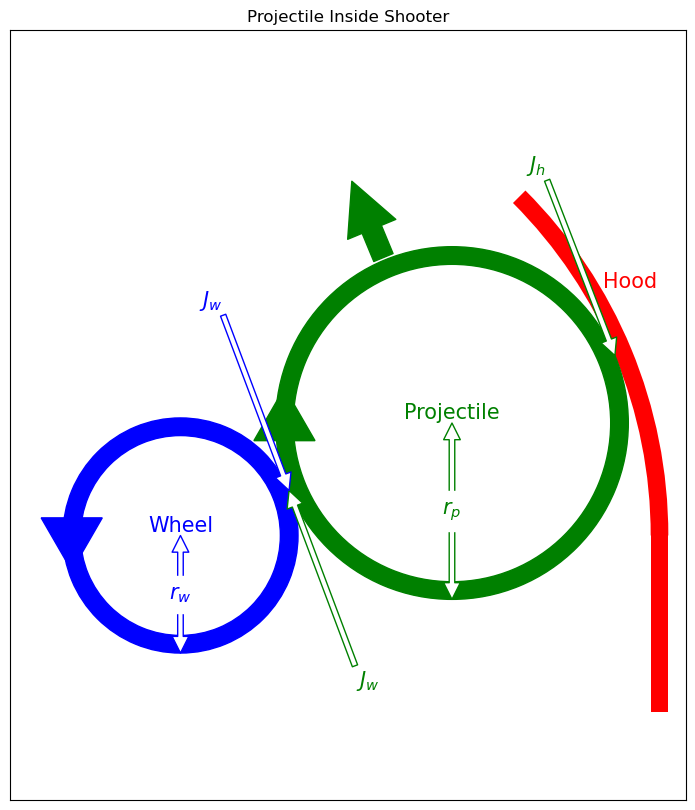

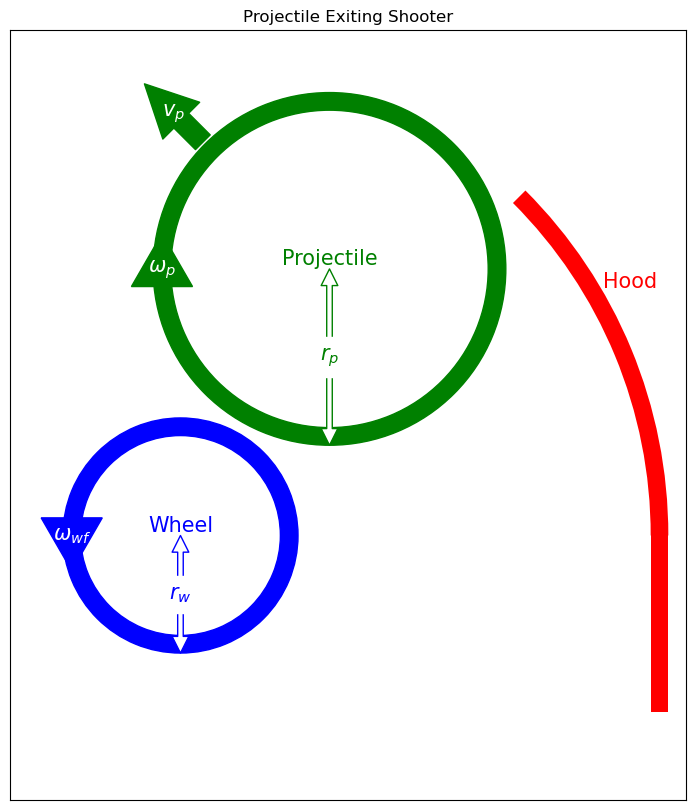

In [254]:
from matplotlib.patches import Circle, Wedge, Polygon, RegularPolygon, Rectangle, FancyArrowPatch
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import numpy
import math

def add_labeled_circle(ax, x, y, radius, width, color, arrow_width, label, radius_label, speed_label, label_size, direction="cw"):
    ax.add_patch(Wedge((x, y), radius, 0, 360, width=width, color=color))
    ax.text(x, y, label, ha="center", va="bottom", color=color, backgroundcolor="w", size=label_size)
    if (speed_label != None):
        ax.add_patch(RegularPolygon((x-radius+width/2, y), 3, radius=2*width, orientation=(math.pi if direction == "cw" else 0), color=color))
        ax.text(x-radius+width/2, y, speed_label, ha="center", va="center", color="w", size=label_size)

    # Radius arrows and label
    ax.annotate("",
                xy=(x, y), xycoords='data',
                xytext=(x, y-radius/2), textcoords='data',
                size=label_size, va="center", ha="center", color=color,
                arrowprops=dict(color=color,
                                fc="w",
                                width=arrow_width),
    )
    ax.annotate("",
                xy=(x, y-radius), xycoords='data',
                xytext=(x, y-radius/2), textcoords='data',
                size=label_size, va="center", ha="center", color=color,
                arrowprops=dict(color=color,
                                fc="w",
                                width=arrow_width),
    )
    ax.text(x, y-radius/2, radius_label, ha="center", va="center", color=color, backgroundcolor="w", size=label_size)



def display_drawing():
    r_w = 0.2
    r_p = 0.3
    r_h = r_w+2*r_p

    def display_shooter(title, omega_w_label, omega_p_label, v_p_label, p_center, show_impulses=False, theta=None):
        fig, ax = plt.subplots(figsize=(10, 10))

        width = 0.03

        w_color = "blue"
        p_color = "green"
        h_color = "red"

        label_size = 15
        arrow_length = 0.35
        arrow_width = 4

        bounds = [-r_w-3*width, r_w+2*r_p+2*width, -r_p-5*width, r_w+2*r_p+2*width]

        # Hood
        ax.text((r_h+width)*math.cos(math.pi/6), (r_h+width)*math.sin(math.pi/6), r'Hood', ha="left", va="bottom", color=h_color, size=label_size)
        ax.add_patch(Wedge((0, 0), r_h, 0, 45, width=-width, color=h_color, linewidth=0))
        ax.add_patch(Rectangle((r_h, 0), width, -r_p, color=h_color, linewidth=0))
        
        # Wheel
        add_labeled_circle(ax, 0, 0, r_w, width, w_color, arrow_width, "Wheel", "$r_w$", omega_w_label, label_size, direction="cw")
        
        # Projectile
        add_labeled_circle(ax, p_center[0], p_center[1], r_p, width, p_color, arrow_width, "Projectile", "$r_p$", omega_p_label, label_size, direction="ccw")

        if v_p_label != None:
            # Projectile velocity
            t = Affine2D().rotate(theta+math.pi/2).translate(p_center[0], p_center[1])
            ax.add_patch(FancyArrowPatch(t.transform((r_p, 0)), t.transform((r_p+0.15, 0)),
                                         color=p_color,
                                         mutation_scale=75
                                         ))
            v_p_label_pos = t.transform((r_p+0.075, 0))
            ax.text(v_p_label_pos[0], v_p_label_pos[1], v_p_label, ha="center", va="center", color="w", size=label_size)
        if show_impulses:
            # Wheel->Projectile impulse
            w_p_contact = ((r_w)*math.cos(theta), (r_w)*math.sin(theta))
            ax.annotate("$J_w$",
                        xy=w_p_contact, xycoords='data',
                        xytext=(w_p_contact[0]+arrow_length*math.cos(theta-math.pi/2), w_p_contact[1]+arrow_length*math.sin(theta-math.pi/2)), textcoords='data',
                        size=label_size, va="center", ha="center", color=p_color,
                        arrowprops=dict(color=p_color,
                                        fc="w",
                                        width=arrow_width),
            )


            # Hood->Projectile impulse
            h_p_contact = ((r_w+2*r_p)*math.cos(theta), (r_w+2*r_p)*math.sin(theta))
            ax.annotate("$J_h$",
                        xy=h_p_contact, xycoords='data',
                        xytext=(h_p_contact[0]+arrow_length*math.cos(theta+math.pi/2), h_p_contact[1]+arrow_length*math.sin(theta+math.pi/2)), textcoords='data',
                        size=label_size, va="center", ha="center", color=p_color,
                        arrowprops=dict(color=p_color,
                                        fc="w",
                                        width=arrow_width),
            )

            # Projectile->Wheel impulse
            ax.annotate("$J_w$",
                        xy=w_p_contact, xycoords='data',
                        xytext=(w_p_contact[0]+arrow_length*math.cos(theta+math.pi/2), w_p_contact[1]+arrow_length*math.sin(theta+math.pi/2)), textcoords='data',
                        size=label_size, va="center", ha="center", color=w_color,
                        arrowprops=dict(color=w_color,
                                        fc="w",
                                        width=arrow_width),
            )

        
        ax.set_title(title)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.axis(bounds)

        plt.show()

    display_shooter('Projectile Entering Shooter', r'$\omega_{wi}$', None, None, (r_w+r_p, -r_p/3))
    display_shooter('Projectile Inside Shooter', r'', r'', r'', ((r_w+r_p)*math.cos(math.pi/8), (r_w+r_p)*math.sin(math.pi/8)), show_impulses=True, theta=math.pi/8)
    display_shooter('Projectile Exiting Shooter', r'$\omega_{wf}$', r'$\omega_p$', r'$v_p$', ((r_w+r_p)*math.cos(math.pi/4)-r_p/3, (r_w+r_p)*math.sin(math.pi/4)+r_p/3), theta=math.pi/4)


display_drawing()



## Assumptions

1. The projectile is rolling against the hood when it exits the shooter.
2. The projectile is rolling against the shooter wheel when it exits the shooter.
3. The shooter wheel has a radius $r_w$, a moment of inertia of $I_w$, and an initial rotational velocity of $\omega_{wi}$.
4. The projectile has a radius $r_p$, a moment of inertia of $I_p$, and an initial rotational velocity of 0.
5. While the projectile is in the shooter:
    1. The contact between the surface of the shooter wheel and the surface of the projectile produces an impulse on each of them (in opposite directions). This impulse decreases the shooter wheel's rotational velocity, and increases both the projectile's rotational velocity, and its linear velocity.
    2. The contact between the hood and the surface of the projectile produces an additional impulse on the projectile, on the opposite side and in the opposite direction. This contact increases the projectile's rotational velocity, but decreases it linear velocity.
    3. There are no other torques or forces acting on either the shooter wheel or the projectile. The projectile spends so little time in the shooter that any attempt to compensate for the decrease in shooter wheel speed will not occur until after the projectile has exited.
6. The mass and moment of inertia of the robot is high enough that neither impulse meaningfully changes the linear or rotational velocity of the robot. As a result the shooter wheel axle and the contact point with the hood are assumed to be fixed.

## The problem

Given $r_p$, $I_p$, $r_w$, $I_w$, and the desired linear velocity of the projectile $v_p$, find the shooter wheel's initial velocity $\omega_{wi}$. It will also be convenient to determine know the wheel's final rotational velocity $\omega_{wf}$, and the projectile's rotational velocity $\omega_p$.

To do this it will be useful to introduce 2 additional unknowns, the magnitudes of the impulses on the wheel side and the hood side of the projectile, $J_w$ and $J_h$ respectively.

## What physics tells us

An object's linear momentum is equal to its mass times its linear velocity.

An impulse causes a change in an object's linear momentum equal to the magnitude of the impulse.

So:

In [2]:
eq1=Eq(m_p*v_p, J_w-J_h)
display_eq(eq1, 'Equation 1')

<div style="text-align: center">

#### Equation 1

</div>

\begin{equation}
m_{p} v_{p} = J_{w} - J_{h} \end{equation}

An object's angular momentum is equal to its moment of inertial times its rotation velocity.

An impulse whose direction is perpendicular to the line between an object's center of mass and the point of contact causes a change in the object's angular momentum (about it's center of mass) equal to the magnitude of the impulse times the distance to the point of contact.

So:

In [3]:
eq2=Eq(I_p*omega_p, J_h*r_p+J_w*r_p)
eq3=Eq(I_w*omega_wi-I_w*omega_wf, J_w*r_w)
display_eq(eq2, 'Equation 2')
display_eq(eq3, 'Equation 3')

<div style="text-align: center">

#### Equation 2

</div>

\begin{equation}
I_{p} \omega_{p} = J_{h} r_{p} + J_{w} r_{p} \end{equation}

<div style="text-align: center">

#### Equation 3

</div>

\begin{equation}
I_{w} \omega_{wi} - I_{w} \omega_{wf} = J_{w} r_{w} \end{equation}

Since we are assuming that when the projectile exits the shooter it is rolling against the hood, it's linear velocity will be half of the linear velocity of the point opposite the hood. So projectile's linear velocity will be half of the linear velocity of the point where the projectile is contacting the wheel. Since the projectile is also rolling against the wheel, the linear velocity of that point is the same as the linear velocity of a point on the surface of the wheel. The linear velocity of a point on a rotating object is the rotational velocity times the distance from the center of rotation to the point.

In [4]:
eq4=Eq(v_p,(omega_wf*r_w)/2)
display_eq(eq4, 'Equation 4')

<div style="text-align: center">

#### Equation 4

</div>

\begin{equation}
v_{p} = \frac{\omega_{wf} r_{w}}{2} \end{equation}

Since the projectile is rolling against the hood, it's linear velocity must also be the same as the linear velocity of a point on the surface of the projectile in when viewed from a frame of reference that is moving at the same linear velocity as the projectile.

In [5]:
eq5=Eq(v_p,omega_p*r_p)
display_eq(eq5, 'Equation 5')

<div style="text-align: center">

#### Equation 5

</div>

\begin{equation}
v_{p} = \omega_{p} r_{p} \end{equation}

## Solving the system of equations

We now have 5 equations and 5 unknowns. We can solve the system using a computer algebra system (as is done in this Jupyter notebook) or solve it manually as follows.

In [6]:
sols = solve([eq1, eq2, eq3, eq4, eq5], [omega_wi, omega_p, omega_wf, J_w, J_h], dict=True)[0]


Rearrange [Equation 4](#Equation-4) to get the wheel's final rotational velocity, $\omega_{wf}$, in terms of $v_p$ and $r_w$:

In [7]:
eq_omega_wf = Eq(omega_wf, sols[omega_wf])
display_eq(eq_omega_wf, "Final wheel rotational velocity")

<div style="text-align: center">

#### Final wheel rotational velocity

</div>

\begin{equation}
\omega_{wf} = \frac{2 v_{p}}{r_{w}} \end{equation}

Rearrange [Equation 5](#Equation-5) to get the projectile's rotational velocity, $\omega_p$, in terms of $v_p$ and $r_p$:

In [8]:
display_eq(Eq(omega_p, sols[omega_p]), "Projectile rotational velocity")

<div style="text-align: center">

#### Projectile rotational velocity

</div>

\begin{equation}
\omega_{p} = \frac{v_{p}}{r_{p}} \end{equation}


Substitute $\omega_p$ into [Equation 2](#Equation-2), divide both sides by $r_p$ and add the resulting equation to [Equation 1](#Equation-1) to get an equation that can be solved for $J_w$:

In [9]:
display_eq(Eq(J_w, factor(sols[J_w])), "Impulse from the wheel")

<div style="text-align: center">

#### Impulse from the wheel

</div>

\begin{equation}
J_{w} = \frac{v_{p} \left(I_{p} + m_{p} r_{p}^{2}\right)}{2 r_{p}^{2}} \end{equation}

Substitute the above formulas for $J_w$ and $\omega_{wf}$ into [Equation 3](#Equation-3) and solve for the wheel's initial rotational velocity, $\omega_{wi}$:

In [10]:
eq_omega_wi = Eq(omega_wi, separatevars(sols[omega_wi]))
display_eq(eq_omega_wi, "Initial wheel rotational velocity")

<div style="text-align: center">

#### Initial wheel rotational velocity

</div>

\begin{equation}
\omega_{wi} = \frac{v_{p} \left(I_{p} r_{w}^{2} + 4 I_{w} r_{p}^{2} + m_{p} r_{p}^{2} r_{w}^{2}\right)}{2 I_{w} r_{p}^{2} r_{w}} \end{equation}

Note that the initial wheel rotational velocity is the projectile velocity multiplied by a constant factor that depends on the physical properties of the wheel and the projectile.

We can also compute the ratio of the wheel's initial and final rotational velocities. Let's call that the wheel velocity ratio.


In [11]:
wheel_velocity_ratio = omega_wi / omega_wf
display_eq(wheel_velocity_ratio, "Wheel velocity ratio")

<div style="text-align: center">

#### Wheel velocity ratio

</div>

\begin{equation}
\frac{\omega_{wi}}{\omega_{wf}} \end{equation}

Substituting the formula for initial and final wheel velocity gives:


In [12]:
wheel_velocity_ratio_expanded = expand(sols[omega_wi]/sols[omega_wf]).collect(r_w**2/(4*I_w), exact=True)
display_eq(wheel_velocity_ratio_expanded, "Value", [r_w**2/(4*I_w)])
eq_wheel_velocity_ratio_expanded = Eq(wheel_velocity_ratio, wheel_velocity_ratio_expanded)
display_eq(eq_wheel_velocity_ratio_expanded, "Wheel velocity ratio", [r_w**2/(4*I_w)])


<div style="text-align: center">

#### Value

</div>

\begin{equation}
1 + \left(m_{p} + \frac{I_{p}}{r_{p}^{2}}\right) \frac{r_{w}^{2}}{4 I_{w}} \end{equation}

<div style="text-align: center">

#### Wheel velocity ratio

</div>

\begin{equation}
\frac{\omega_{wi}}{\omega_{wf}} = 1 + \left(m_{p} + \frac{I_{p}}{r_{p}^{2}}\right) \frac{r_{w}^{2}}{4 I_{w}} \end{equation}



The moment of inertia of an axially symmetric object varies linearly with it's mass and the square of it's radius. So $I=k m r^2$ for some $k$ which will call the *shape factor* because it depends on the shape of the object. For a solid cylinder, $k=1/2$. For a solid sphere, $k=2/5$. For more examples, see [this list](https://en.wikipedia.org/wiki/List_of_moments_of_inertia).

Let's define $I_w$, and $I_p$ as follows:

In [13]:
k_p = symbols("k_p", real=True, finite=True, positive=True)
m_p = symbols("m_p", real=True, finite=True, positive=True)
eq6 = Eq(I_p, k_p*m_p*r_p**2)
display_eq(eq6, "Equation 6")

k_w = symbols("k_w", real=True, finite=True, positive=True)
m_w = symbols("m_w", real=True, finite=True, positive=True)
eq7 = Eq(I_w, k_w*m_w*r_w**2)
display_eq(eq7, "Equation 7")


<div style="text-align: center">

#### Equation 6

</div>

\begin{equation}
I_{p} = k_{p} m_{p} r_{p}^{2} \end{equation}

<div style="text-align: center">

#### Equation 7

</div>

\begin{equation}
I_{w} = k_{w} m_{w} r_{w}^{2} \end{equation}

In [14]:
wheel_velocity_ratio_k = solve([eq_wheel_velocity_ratio_expanded, eq6, eq7], [wheel_velocity_ratio, I_p, I_w, m_p, m_w], dict=True)[0][wheel_velocity_ratio]
wheel_velocity_ratio_k = expand(wheel_velocity_ratio_k).collect(m_p/m_w*1/(4*k_w))
eq_wheel_velocity_ratio_k = Eq(wheel_velocity_ratio, wheel_velocity_ratio_k)

eq_omega_wi_k = Eq(omega_wi, sols[omega_wf]*wheel_velocity_ratio_k)

display_eq(eq_omega_wi_k, "Initial wheel rotational velocity with shape factors", [sols[omega_wf], m_p/m_w, (1+k_p)/(4*k_w)])
display_eq(eq_wheel_velocity_ratio_k, "Wheel velocity ratio with shape factors", [m_p/m_w, (1+k_p)/(4*k_w)])


<div style="text-align: center">

#### Initial wheel rotational velocity with shape factors

</div>

\begin{equation}
\omega_{wi} = \left(1 + \frac{1 + k_{p}}{4 k_{w}} \frac{m_{p}}{m_{w}}\right) \frac{2 v_{p}}{r_{w}} \end{equation}

<div style="text-align: center">

#### Wheel velocity ratio with shape factors

</div>

\begin{equation}
\frac{\omega_{wi}}{\omega_{wf}} = 1 + \frac{1 + k_{p}}{4 k_{w}} \frac{m_{p}}{m_{w}} \end{equation}

If we assume a solid cylindrical shooter wheel (i.e. $k_w=1/2$) and a solid spherical projectile (i.e. $k_p=2/5$) we get the following:

In [15]:
eq8=Eq(k_p, Rational(2, 5))
eq9=Eq(k_w, Rational(1, 2))
# one_plus_k_p_over_4k_w_cylinder_sphere = solve([eq_one_plus_k_p_over_4k_w, eq_one_plus_k_p, eq8, eq9], [one_plus_k_p_over_4k_w, one_plus_k_p, k_p, k_w], dict=True)[0][one_plus_k_p_over_4k_w]
# wheel_velocity_ratio_cylinder_sphere=solve([eq_wheel_velocity_ratio_k, Eq(one_plus_k_p_over_4k_w, one_plus_k_p_over_4k_w_cylinder_sphere)], [one_plus_k_p_over_4k_w, wheel_velocity_ratio], dict=True)[0][wheel_velocity_ratio].subs(7*mass_ratio/10, Mul(UnevaluatedExpr(Rational(7, 10)), mass_ratio, evaluate=False))
wheel_velocity_ratio_cylinder_sphere = solve([eq_wheel_velocity_ratio_k, eq8, eq9], [wheel_velocity_ratio, k_p, k_w], dict=True)[0][wheel_velocity_ratio]
wheel_velocity_ratio_cylinder_sphere = expand(wheel_velocity_ratio_cylinder_sphere).collect(m_p/m_w)
eq_omega_wi_cylinder_sphere = Eq(omega_wi, sols[omega_wf]*wheel_velocity_ratio_cylinder_sphere)

display_eq(eq_omega_wi_cylinder_sphere, "Initial wheel rotational velocity with cylindrical wheel and spherical ball", [sols[omega_wf], m_p/m_w, Rational(7, 10)])
display_eq(Eq(wheel_velocity_ratio, wheel_velocity_ratio_cylinder_sphere), "Wheel velocity ratio with cylindrical wheel and spherical ball", [m_p/m_w, Rational(7, 10)])



<div style="text-align: center">

#### Initial wheel rotational velocity with cylindrical wheel and spherical ball

</div>

\begin{equation}
\omega_{wi} = \left(1 + \frac{7}{10} \frac{m_{p}}{m_{w}}\right) \frac{2 v_{p}}{r_{w}} \end{equation}

<div style="text-align: center">

#### Wheel velocity ratio with cylindrical wheel and spherical ball

</div>

\begin{equation}
\frac{\omega_{wi}}{\omega_{wf}} = 1 + \frac{7}{10} \frac{m_{p}}{m_{w}} \end{equation}

## Comparison with earlier work

In 2012, FRC Team 846, the Funky Monkeys, did the most frequently cited [analysis of flywheel shooters](https://web.archive.org/web/20150920073053/https:/lynbrookrobotics.com/resourcefiles/whitepages/2012/Shooter%20Calculations%20Document.pdf) to date. Others used their whitepaper to create [a spreadsheet calculator](https://www.chiefdelphi.com/t/flywheel-calculator/372836) that is the top Chief Delphi search result for "flywheel calculator", and [an online calculator](https://www.reca.lc/flywheel) based on that spreadsheet calculator. Team 846 has also posted [a YouTube video](https://www.youtube.com/watch?v=g8lGrWJ6BHc) describing their analysis in more detail.

That analysis is based on the conservation of linear momentum and the incorrect idea that the angular momentum of the wheel and the projectile can be converted to linear momentum my dividing each of those angular momenta by their respective radii. However, linear and angular momentum are different physical quantities and such a conversion is only justified when the the system consists of a point mass moving in a circle. Neither the wheel nor the projectile are such systems.

Interestingly, that analysis yields the following formula for the wheel velocity ratio:

In [19]:
display_eq(Eq(omega_wi/omega_wf, 1+(1+k_p)/(2*k_w)*(m_p/m_w)), "Wheel velocity ratio from Team 846's analysis", [m_p/m_w, (1+k_p)/(2*k_w)])

<div style="text-align: center">

#### Wheel velocity ratio from Team 846's analysis

</div>

\begin{equation}
\frac{\omega_{wi}}{\omega_{wf}} = 1 + \frac{1 + k_{p}}{2 k_{w}} \frac{m_{p}}{m_{w}} \end{equation}

Note that the difference between their formula and the formula derived above, is that where they have a 2 in the denominator, we have a 4. As a result, our analysis predicts that only half as much wheel speed loss as their analysis.

In [16]:
from IPython.core.display import HTML
HTML('''<script>
    var code_show = true; 
    function code_toggle() {
        var selected_elements = document.querySelectorAll('.jp-CodeCell > .jp-Cell-inputWrapper, .jp-OutputPrompt');
        selected_elements.forEach( (e) => { e.style.display = code_show ? null : "none"; });
        code_show = !code_show;
    } 
    document.onreadystatechange = () => {
        if (document.readyState === "complete") {
            code_toggle();
        }
    }
    </script>
    ''')

To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.